In [646]:
%reset -fs
from bs4 import BeautifulSoup
import requests
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import numpy as np
%matplotlib inline

In [647]:
year = 2016 # initializing parameters
year_range = [0, 1, 2, 3]
params = 'player_age,p_game,p_formatted_ip,p_k_percent,p_bb_percent,slg_percent,on_base_percent,p_era,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,in_zone_percent,whiff_percent,swing_percent,fastball_avg_speed,fastball_avg_break,n_breaking_formatted,breaking_avg_break,'
# web_address = f'https://baseballsavant.mlb.com/leaderboard/custom?year={year}&type=pitcher&filter=&sort=4&sortDir=asc&min=50&selections={params}&chart=false&x=player_age&y=player_age&r=no&chartType=beeswarm'
params_list = params.split(",")
del params_list[-1]
params_list

['player_age',
 'p_game',
 'p_formatted_ip',
 'p_k_percent',
 'p_bb_percent',
 'slg_percent',
 'on_base_percent',
 'p_era',
 'exit_velocity_avg',
 'launch_angle_avg',
 'sweet_spot_percent',
 'in_zone_percent',
 'whiff_percent',
 'swing_percent',
 'fastball_avg_speed',
 'fastball_avg_break',
 'n_breaking_formatted',
 'breaking_avg_break']

In [648]:
chromedriver = "/Applications/chromedriver" # initiating selenium
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)

In [649]:
params_list.insert(0, 'name') # Adding name and year to the params list
params_list.insert(1, 'year')

In [650]:
def populate_table(player_e, params_l): # Reading in all the rows and populate the dataframe
    df_out = pd.DataFrame(columns = params_l) # Setting up the dataframe
    for p in player_e: # reading in each row
        stats = p.find_all('span') # creating a list with all the stats
        row_in = {}
        for j in range(len(stats)): # setting each param in the params list to the value in table
            row_in[params_list[j]] = stats[j].text
        df_out = df_out.append(row_in, ignore_index = True) # appending each row to the dataframe
    for j in df_out.columns[1:]: # making sure each column that isn't [name, year] is numeric
        df_out[j] = pd.to_numeric(df_out[j])
    return df_out

In [651]:
df_list = []
for i in year_range: # making a df for each year 2016-2019
    web_address = f'https://baseballsavant.mlb.com/leaderboard/custom?year={year + i}&type=pitcher&filter=&sort=4&sortDir=asc&min=50&selections={params}&chart=false&x=player_age&y=player_age&r=no&chartType=beeswarm'
    driver.get(web_address) # opening the page
    time.sleep(10) # letting it load
    soup = BeautifulSoup(driver.page_source, 'html.parser') # reading in the html
    player_entries = soup.find('tbody').find_all('tr') # reading in each row
    df_list.append(populate_table(player_entries, params_list)) # populating the table then appending it

In [652]:
def starter_bool(avg_ip_per_g): # determining whether a pitcher is a starter or reliever
    if avg_ip_per_g > 2:
        return 1
    else:
        return 0
def fix_innings(innings): # fixing inning notation
    if (innings % 1 > 0.15):
        return innings + 0.47
    elif (innings % 1 > .05):
        return innings + 0.23
    else:
        return innings

    
for i in range(len(df_list)):
    df_list[i]['p_formatted_ip'] = df_list[i]['p_formatted_ip'].apply(fix_innings)
    
for i in range(len(df_list) - 1): # changing games to is_starter, adding next_year_ip, renaming columns
    df_list[i]['p_game'] = df_list[i]['p_formatted_ip'] / df_list[i]['p_game']
    df_list[i]['p_game'] = df_list[i]['p_game'].apply(starter_bool)
    df_list[i] = df_list[i].join(df_list[i+1][['name', 'p_formatted_ip']].set_index('name').rename(columns = {'p_formatted_ip':'next_year_ip'}), on = 'name')
    df_list[i].dropna(inplace = True)
    df_list[i].rename(columns = {'player_age': 'age',
                                 'p_game': 'is_starter',
                                 'p_formatted_ip': 'ip',
                                 'p_k_percent': 'k%',
                                 'p_bb_percent': 'bb%',
                                 'slg_percent': 'slg',
                                 'on_base_percent': 'obp',
                                 'p_era': 'era',
                                 'exit_velocity_avg': 'avg_ev',
                                 'launch_angle_avg': 'avg_la',
                                 'sweet_spot_percent': 'sweet%',
                                 'in_zone_percent': 'zone%',
                                 'whiff_percent': 'whiff%',
                                 'swing_percent': 'swing%',
                                 'fastball_avg_speed': 'fb_speed',
                                 'fastball_avg_break': 'fb_break',
                                 'n_breaking_formatted': 'breaking%',
                                 'breaking_avg_break': 'breaking_break'
                                 }, inplace = True)
    for column in ['k%', 'bb%', 'sweet%', 'zone%', 'whiff%', 'swing%', 'breaking%']: # making percentages out of 1 instead of 100
        df_list[i][column] = df_list[i][column] / 100





In [653]:
df_all = pd.concat([df_list[0], df_list[1], df_list[2]], ignore_index = True) # Stacking the different years on top of each other
df_all.rename(columns = {'p_game':'is_starter'}, inplace = True)
df_all.to_csv('pitching_stats_2016-2018')

In [654]:
#df_all = pd.read_csv('pitching_stats_2016-2018') # refreshing df_all

In [655]:


df_all.sample(10)

,name,year,age,is_starter,ip,k%,bb%,slg,obp,era,...,avg_la,sweet%,zone%,whiff%,swing%,fb_speed,fb_break,breaking%,breaking_break,next_year_ip
133,"Logan, Boone",2016,32,0,46.33,0.305,0.107,0.313,0.262,3.69,...,7.8,0.343,0.429,0.374,0.455,93.7,19.8,0.526,5.2,21.00
316,"Bundy, Dylan",2016,24,1,109.67,0.219,0.089,0.434,0.331,4.02,...,17.1,0.351,0.513,0.242,0.497,94.4,23.8,0.184,12.6,169.67
565,"De La Rosa, Jorge",2017,36,0,51.33,0.205,0.096,0.396,0.320,4.21,...,12.2,0.233,0.468,0.304,0.501,92.2,16.7,0.053,16.4,56.00
570,"Cole, A.J.",2017,25,1,52.00,0.192,0.118,0.441,0.354,3.81,...,14.2,0.329,0.482,0.239,0.451,93.1,19.6,0.387,9.9,48.33
934,"Toussaint, Touki",2018,22,1,29.00,0.260,0.171,0.283,0.333,4.03,...,5.5,0.338,0.437,0.273,0.361,93.1,15.8,0.262,18.2,41.67
828,"Bauer, Trevor",2017,26,1,176.33,0.262,0.080,0.446,0.328,4.19,...,9.7,0.361,0.493,0.237,0.422,92.5,18.3,0.312,17.6,175.33
482,"Stephens, Jackson",2017,23,1,25.00,0.208,0.089,0.440,0.287,4.68,...,19.3,0.329,0.495,0.194,0.486,93.6,18.7,0.312,13.7,38.33
252,"Cessa, Luis",2016,24,1,70.33,0.161,0.049,0.459,0.284,4.35,...,11.8,0.329,0.485,0.241,0.466,95.2,21.0,0.392,6.7,36.00
381,"Ray, Robbie",2016,25,1,174.33,0.281,0.091,0.431,0.338,4.90,...,12.4,0.322,0.503,0.266,0.466,94.8,22.6,0.226,7.0,162.00
139,"Rzepczynski, Marc",2016,31,0,47.67,0.214,0.135,0.328,0.367,2.64,...,-0.8,0.206,0.370,0.284,0.415,91.8,19.5,0.255,5.2,31.33


In [656]:
# sns.pairplot(df_all)

In [657]:
# Checking model for just starters or relievers, or players that pitched a lot both years
# df_all = df_all.loc[df_all['is_starter'] == 1]
# df_all = df_all.loc[(df_all['ip'] > 80) & (df_all['next_year_ip'] > 80)]
df_all.sample(10)

,name,year,age,is_starter,ip,k%,bb%,slg,obp,era,...,avg_la,sweet%,zone%,whiff%,swing%,fb_speed,fb_break,breaking%,breaking_break,next_year_ip
1242,"Cashner, Andrew",2018,32,1,153.00,0.145,0.095,0.496,0.360,5.29,...,13.4,0.364,0.484,0.172,0.436,92.4,20.3,0.264,8.7,150.00
420,"Iwakuma, Hisashi",2016,35,1,199.00,0.176,0.055,0.452,0.322,4.12,...,14.6,0.335,0.530,0.174,0.488,88.1,18.1,0.275,10.1,31.00
284,"Nicolino, Justin",2016,25,1,79.33,0.107,0.058,0.450,0.344,4.99,...,10.7,0.346,0.497,0.118,0.464,89.1,19.1,0.120,5.2,48.00
130,"Green, Chad",2016,25,1,45.67,0.263,0.076,0.522,0.328,4.73,...,10.5,0.408,0.484,0.273,0.472,94.0,19.9,0.293,3.7,69.00
1015,"Barnes, Jacob",2018,28,0,48.67,0.217,0.106,0.380,0.341,3.33,...,8.0,0.259,0.473,0.300,0.483,92.7,10.8,0.002,5.0,32.67
414,"Arrieta, Jake",2016,30,1,197.33,0.239,0.096,0.306,0.277,3.10,...,6.5,0.308,0.498,0.250,0.456,94.4,21.5,0.303,11.2,168.33
191,"Quackenbush, Kevin",2016,28,0,59.67,0.166,0.087,0.436,0.304,3.92,...,14.3,0.376,0.486,0.185,0.437,91.1,20.4,0.362,11.7,26.33
775,"Holland, Derek",2017,31,1,135.00,0.166,0.120,0.535,0.382,6.20,...,14.2,0.379,0.458,0.188,0.412,91.1,18.5,0.345,6.9,171.33
164,"Guerra, Deolis",2016,27,0,53.33,0.164,0.032,0.392,0.277,3.21,...,13.4,0.366,0.475,0.218,0.483,90.8,23.4,0.075,12.8,25.00
883,"Almonte, Yency",2018,24,0,14.67,0.233,0.067,0.418,0.317,1.84,...,7.6,0.405,0.482,0.260,0.522,95.4,14.9,0.347,5.4,34.00


In [658]:
# Squaring some rate stats - This was unhelpful
# df_all['k%^2'] = df_all['k%'] ** 2
# df_all['bb%^2'] = df_all['bb%'] ** 2
# df_all['zone%^2'] = df_all['zone%'] ** 2
# df_all['whiff%^2'] = df_all['whiff%'] ** 2
# df_all['swing%^2'] = df_all['swing%'] ** 2
# df_all['breaking%^2'] = df_all['breaking%'] ** 2

lambda: 0.09382694043801469


(array([ 25.,  58.,  85., 118., 174., 313., 162.,  88., 146., 145.]),
 array([2.44011387, 2.9004468 , 3.36077973, 3.82111266, 4.28144559,
        4.74177852, 5.20211145, 5.66244438, 6.12277731, 6.58311023,
        7.04344316]),
 <BarContainer object of 10 artists>)

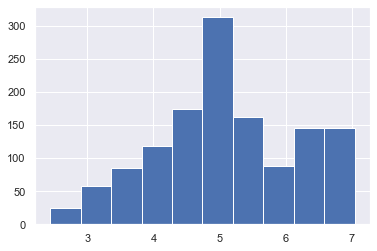

In [659]:
lamb = stats.boxcox_normmax(df_all['next_year_ip']) # Trying out a boxcox transformation to deal with heteroskedasticity
print('lambda:', lamb)
y_t = (np.power(df_all['next_year_ip'], lamb) - 1)/lamb
plt.hist(y_t)

In [660]:

X, X_test, y, y_test = train_test_split(df_all[['age', 'is_starter', 'ip', 'k%', 'bb%', 'slg', 'obp',
                                               'era', 'avg_ev', 'avg_la', 'sweet%', 'zone%', 'whiff%', 'swing%',
                                               'fb_speed', 'fb_break', 'breaking%', 'breaking_break']],
                                        df_all['next_year_ip'], test_size = 0.2, random_state = 25)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 25)

In [661]:

#import statsmodels.formula.api as smf
#from sklearn.linear_model import Lasso, LassoCV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [662]:
for i in [0.001, 0.01, 0.1, 1, 10]:
    lasso_model = Lasso(alpha = i)
    lasso_model.fit(X_train_scaled, y_train)
    for col, coef in zip(X_train.columns, lasso_model.coef_):
        print(f"{col}: {coef}")
    print("---")

age: 0.05723964171008704
is_starter: 18.236600662606893
ip: 22.451555288810564
k%: 4.692549473377309
bb%: -4.379955415568563
slg: -0.1713412820274294
obp: 2.2384631657619836
era: -1.524508963043976
avg_ev: -2.247404261312217
avg_la: -2.196734961419981
sweet%: -1.3141630120647971
zone%: -0.170133986949268
whiff%: -0.31084210026797393
swing%: -0.9307561693026472
fb_speed: 5.773160502869572
fb_break: 1.007304941990131
breaking%: -1.8679686679469547
breaking_break: 2.111549791497772
---
age: 0.04224073050872697
is_starter: 18.220063694167813
ip: 22.458355793684298
k%: 4.617474367276917
bb%: -4.307609664480722
slg: -0.12135960871054957
obp: 2.1217259658852337
era: -1.4993594797169252
avg_ev: -2.237287372853116
avg_la: -2.2168102808935406
sweet%: -1.297538255353867
zone%: -0.1452208593329748
whiff%: -0.25987920639047324
swing%: -0.9178854816016783
fb_speed: 5.748553946686371
fb_break: 0.998593436435771
breaking%: -1.8589702006561317
breaking_break: 2.1065885067194388
---
age: 0.0
is_starter:

In [663]:
lasso_model = Lasso(alpha = 0.03)
lasso_model.fit(X_train_scaled, y_train)
lasso_model.score(X_val_scaled, y_val)

0.45780672416872836

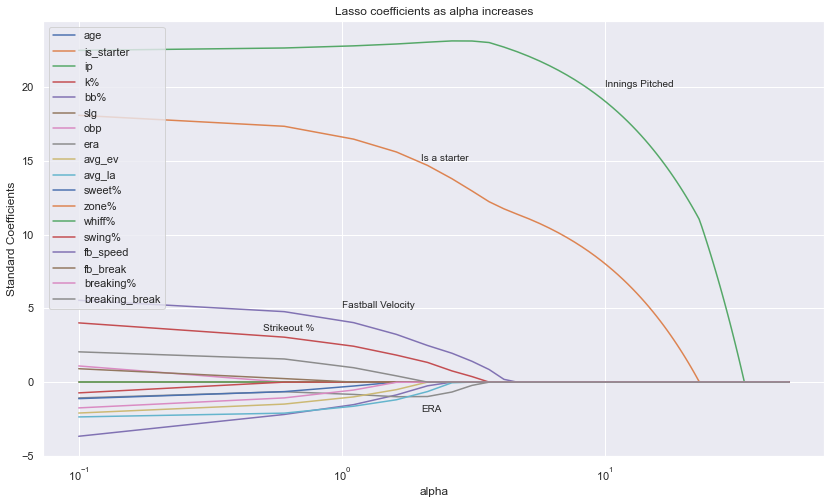

In [664]:
alphas = np.linspace(0.1, 50, 100) # graphing lambda in lasso regression
lasso = Lasso(max_iter = 100)
coefs = np.array([])
for i in alphas:
    lasso.set_params(alpha = i)
    lasso.fit(X_train_scaled, y_train)
    if np.count_nonzero(coefs) > 0:
        coefs = np.vstack([coefs, lasso.coef_])
    else:
        coefs = np.array(lasso.coef_)


fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(8)
ax = plt.gca()
for a, b in zip(coefs.T, X_train.columns):
    ax.plot(alphas, a, label = b)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standard Coefficients')
plt.title('Lasso coefficients as alpha increases')
plt.text(10, 20, 'Innings Pitched')
plt.text(2, 15, 'Is a starter')
plt.text(1, 5, 'Fastball Velocity')
plt.text(0.5, 3.5, 'Strikeout %')
plt.text(2, -2, 'ERA')
plt.legend(loc = 'best');

In [665]:
X_train_ols = sm.add_constant(X_train_scaled)

In [666]:
model = sm.OLS(y_train, X_train_ols)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           next_year_ip   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     39.26
Date:                Fri, 28 Jan 2022   Prob (F-statistic):           5.35e-96
Time:                        00:05:54   Log-Likelihood:                -3992.5
No. Observations:                 788   AIC:                             8023.
Df Residuals:                     769   BIC:                             8112.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.7034      1.384     57.582      0.000      76.986      82.421
x1             0.0589      1.647      0.036      0.971      -3.174       3.292
x2            18.2384      2.123      8.590      0.000      14.070      22.407
x3            22.4508      1.969     11.400      0.000      18.585      26.317
x4             4.7004      3.024      1.554      0.121      -1.236      10.637
x5            -4.3877      2.577     -1.703      0.089      -9.446       0.671
x6            -0.1764      3.287     -0.054      0.957      -6.628       6.275
x7             2.2509      3.408      0.660      0.509      -4.440       8.942
x8            -1.5274      2.852     -0.536      0.592      -7.126       4.071
x9            -2.2485      1.589     -1.415      0.157      -5.367       0.870
x10           -2.1946      1.912     -1.148      0.251      -5.947       1.558
x11           -1.3160      1.715     -0.767      0.443      -4.684       2.052
x12           -0.1728      1.711     -0.101      0.920      -3.532       3.186
x13           -0.3161      2.938     -0.108      0.914      -6.083       5.451
x14           -0.9322      2.133     -0.437      0.662      -5.119       3.254
x15            5.7760      1.881      3.071      0.002       2.084       9.468
x16            1.0083      1.566      0.644      0.520      -2.065       4.082
x17           -1.8690      1.508     -1.239      0.216      -4.830       1.092
x18            2.1121      1.569      1.346      0.179      -0.967       5.192
==============================================================================
Omnibus:                       10.857   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               17.191
Skew:                           0.043   Prob(JB):                     0.000185
Kurtosis:                       3.718   Cond. No.                         6.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [667]:
model_coef = fit.params[1:]
model_coef.index = X_train.columns

In [668]:
coef_df = pd.DataFrame(model_coef)
coef_df.reset_index(inplace = True, drop = False)
coef_df.columns = ['category', 'coefficient_value']
coef_df.sort_values(by = 'coefficient_value', inplace = True, ascending = False)

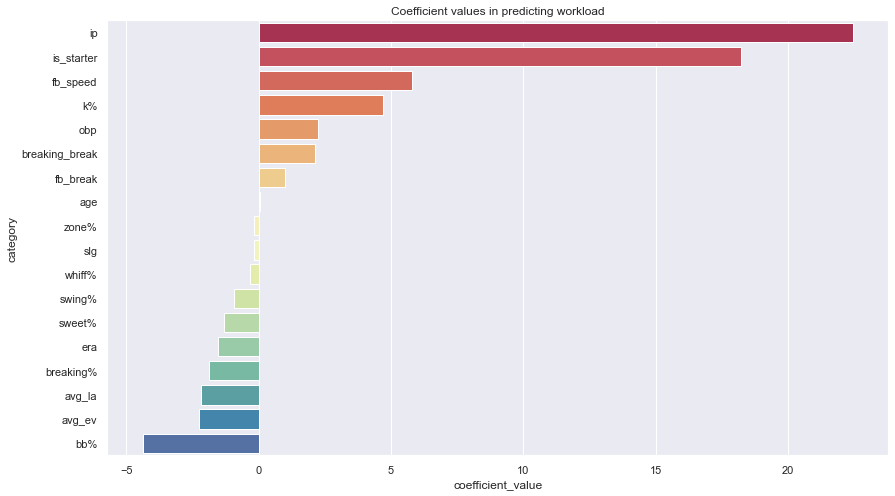

In [669]:

sns.set(rc = {'figure.figsize': (14,8)})
sns.barplot(x = 'coefficient_value', y = 'category', data = coef_df, palette = "Spectral").set_title('Coefficient values in predicting workload')
sns.axes_style('darkgrid');

In [670]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.4788800519283989

In [671]:
# 0.44, 0.54

In [672]:
lr.score(X_val, y_val)

0.45760533689381266

In [673]:
def reg_plot(y_pred, y_true): # diagnostic plots from Wednesday's pair
    resid = y_pred - y_true
    fig, axes = plt.subplots(1, 3, figsize = (14,6))
    
    g1 = sns.regplot(x = y_pred, y = y_true, ci = 0, fit_reg = False, ax = axes[0], scatter_kws = {'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color = 'gray')
    
    g2 = sns.regplot(x = y_pred, y = resid, lowess = True, ax = axes[1], scatter_kws = {'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y = 0, color = 'gray', linestyle = '--')
    
    stats.probplot(resid, dist = 'norm', plot = axes[2])
    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();


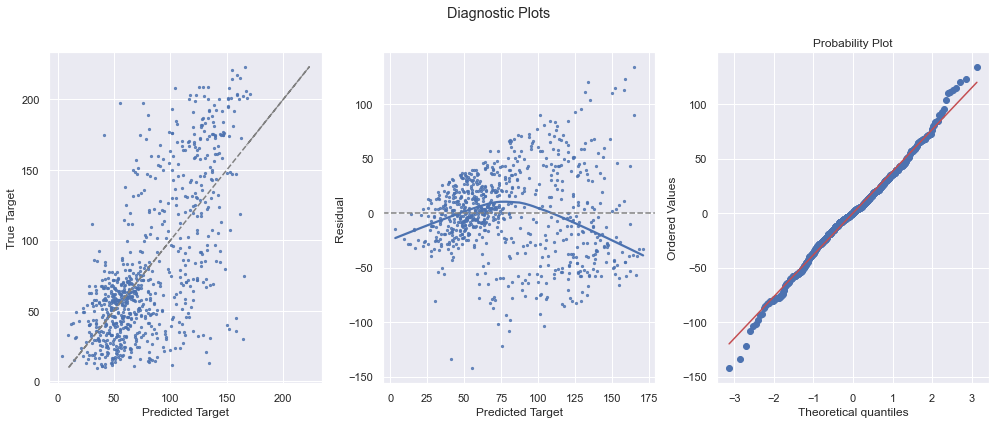

In [674]:
reg_plot(lr.predict(X_train), y_train) # Heteroskedacity seems inherent to the problem

In [686]:
from sklearn.model_selection import cross_val_score, KFold # Cross-validation scoring the different models
lm = LinearRegression()

kf = KFold(n_splits = 7, shuffle = True, random_state = 3)
np.mean(cross_val_score(lm, X, y, cv = kf, scoring = 'r2'))
np.mean(cross_val_score(lasso_model, X, y, cv = kf, scoring = 'r2'))

0.4490279772600756

In [687]:
lasso_model = LassoCV(alphas = np.linspace(0.01, 1, 50), cv = kf, n_jobs = -1)
lasso_model.fit(X,y)
lasso_model.alpha_

0.030204081632653063

In [692]:
lasso_model.coef_


array([  0.12133046,  36.58817023,   0.40788622,  33.91608564,
       -68.53181251,  13.53678509,  -0.        ,  -0.9942891 ,
        -1.35829193,  -0.66185894,  -0.        ,   0.        ,
         0.        ,   0.        ,   2.27669844,   0.1127287 ,
        -7.97093883,   0.49285027])

In [691]:

s = pd.Series(lasso_model.coef_, X.columns)
s
coef_df = pd.DataFrame(s)
coef_df.reset_index(inplace = True, drop = False)
coef_df.columns = ['category', 'coefficient_value']
coef_df.sort_values(by = 'coefficient_value', inplace = True, ascending = False)
coef_df

,category,coefficient_value
1,is_starter,36.588170
3,k%,33.916086
5,slg,13.536785
14,fb_speed,2.276698
17,breaking_break,0.492850
2,ip,0.407886
0,age,0.121330
15,fb_break,0.112729
6,obp,-0.000000
10,sweet%,-0.000000


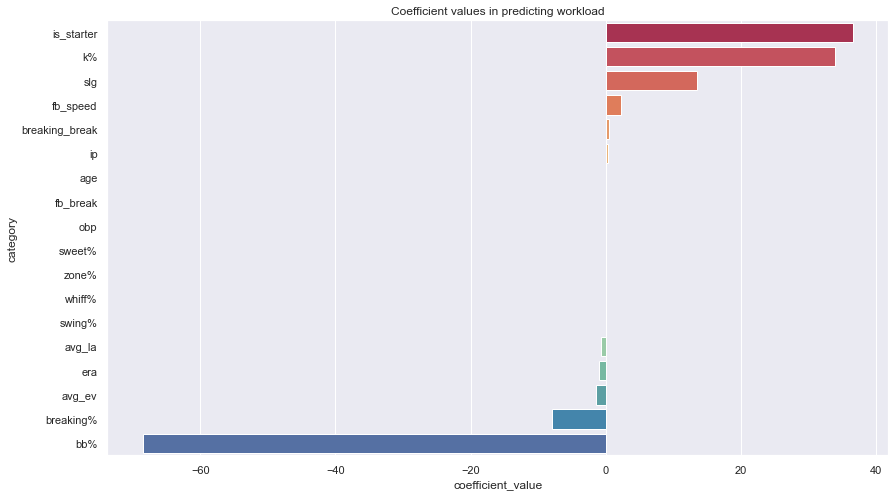

In [690]:
sns.set(rc = {'figure.figsize': (14,8)})
sns.barplot(x = 'coefficient_value', y = 'category', data = coef_df, palette = "Spectral").set_title('Coefficient values in predicting workload')
sns.axes_style('darkgrid');